<h1 style="font-size:3rem;color:blue;">Python Analysis Practice of Single-Cell RNAseq Data</h1>

# Data Source

In [1]:
# All data used in this exercise has been sourced from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524
# This script is primarily used for data analysis practice for GitHub user CPalmer3200

# Installing scanpy module and importing data

In [56]:
# !pip install scanpy

In [2]:
import scanpy as sc

In [3]:
data1 = sc.read_csv('C:/Users/chris/Single cell practice/GSM5226574_C51ctr_raw_counts.csv').T
data1

AnnData object with n_obs × n_vars = 6099 × 34546

# Pre-processing - doublet removal

In [ ]:
# Initial stage to pre-processing is doublet removal
# This will allow the computer to predict doublets (when two or more cells are mistaken as a single cell)
# This should be done on individual samples instead of integrated samples

In [57]:
# !pip install scvi-tools

In [58]:
# !pip install torchaudio

In [4]:
import scvi
scvi.settings.seed = 0

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\ProgramData\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please 

In [5]:
# Filter genes out that appear in fewer than 10 cells
sc.pp.filter_genes(data1, min_cells = 10)

In [6]:
data1

AnnData object with n_obs × n_vars = 6099 × 19896
    var: 'n_cells'

In [59]:
# !pip install --user scikit-misc

In [8]:
# Keep 2000 top variable genes (2000 genes that describe the data the best)
sc.pp.highly_variable_genes(data1, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [9]:
# Setup SCVI model with default parameters and train
scvi.model.SCVI.setup_anndata(data1)
vae = scvi.model.SCVI(data1)
vae.train()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████████████| 400/400 [10:05<00:00,  1.53s/it, v_num=1, train_loss_step=313, train_loss_epoch=323]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████| 400/400 [10:05<00:00,  1.51s/it, v_num=1, train_loss_step=313, train_loss_epoch=323]


In [10]:
# Create solo model which predicts doublets and pass the vae model through
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 213/400:  53%|████▊    | 213/400 [01:05<00:57,  3.25it/s, v_num=1, train_loss_step=0.398, train_loss_epoch=0.297]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.302. Signaling Trainer to stop.


In [11]:
# Return df and make new column with predicted label
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,1.149628,-0.526958,doublet
ATTCACTGTAACAGGC-1_1,1.781324,-1.238426,doublet
TAACTTCCAACCACGC-1_1,0.245325,-0.568828,doublet
TTGGGTACACGACAAG-1_1,0.451471,0.491545,singlet
AGGCCACAGAGTCACG-1_1,1.018245,-0.219212,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,-0.873083,1.699966,singlet
CACTGGGGTCTACGTA-1_1,-3.327643,3.169292,singlet
CATACTTGTAGAGGAA-1_1,-2.993584,2.840208,singlet
TTTGGTTTCCACGGAC-1_1,-3.921782,4.557014,singlet


In [12]:
#Count the predictions
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1045,1045
singlet,5054,5054


In [13]:
#Assign the predicted doublets to their own df - this will be used to filter data1
doublets = df[(df.prediction == 'doublet')]
doublets

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,1.149628,-0.526958,doublet
ATTCACTGTAACAGGC-1_1,1.781324,-1.238426,doublet
TAACTTCCAACCACGC-1_1,0.245325,-0.568828,doublet
AGGCCACAGAGTCACG-1_1,1.018245,-0.219212,doublet
CACTGAAGTCGAAGCA-1_1,1.080889,-0.391635,doublet
...,...,...,...
ACCCTTGAGACTTCCA-1_1,0.142700,-0.143032,doublet
CAACAACAGGTGCTTT-1_1,0.807677,-0.379632,doublet
GACTATGAGTTGCCTA-1_1,0.245119,-0.399316,doublet
GGAGGTAGTTAAGCAA-1_1,0.291436,-0.348957,doublet


In [14]:
# Reload data1 variable
data1 = sc.read_csv('C:/Users/chris/Single cell practice/GSM5226574_C51ctr_raw_counts.csv').T
data1

AnnData object with n_obs × n_vars = 6099 × 34546

In [17]:
# Add binary variable to check if data1 objects are predicted doublets
data1.obs['doublet'] = data1.obs.index.isin(doublets.index)
data1.obs

C:\Users\chris\AppData\Local\Temp\ipykernel_2704\658753045.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data1.obs['doublet'] = data1.obs.index.isin(doublets.index)


,doublet
TTGGGTACACGACAAG-1_1,False
TTACCGCCACTCAGAT-1_1,False
TTGGTTTTCCTAGCTC-1_1,False
TAACGACAGATGACCG-1_1,False
TCTTAGTGTATGAGGC-1_1,False
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [18]:
# Filter out the predicted doublets that appear true (DOUBLET REMOVAL COMPLETE)
data1 = data1[~data1.obs.doublet]

# Pre-processing - labelling of mitochondrial genes

In [19]:
# Mitochondrial genes start with MT- so use python to filter these
data1.var['mt'] = data1.var.index.str.startswith('MT-')
data1.var

C:\Users\chris\AppData\Local\Temp\ipykernel_2704\2113464575.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  data1.var['mt'] = data1.var.index.str.startswith('MT-')


,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


# Pre-processing - labelling ribosomal genes

In [20]:
import pandas as pd

In [21]:
#Import list of ribosomal gene names for filtering
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [22]:
# Format list of ribosomal genes
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [23]:
# Check if genes in data1 are present in the ribo_genes list
data1.var['ribo'] = data1.var_names.isin(ribo_genes[0].values)
data1.var

,mt,ribo
AL627309.1,False,False
AL627309.5,False,False
AL627309.4,False,False
AL669831.2,False,False
LINC01409,False,False
...,...,...
VN1R2,False,False
AL031676.1,False,False
SMIM34A,False,False
AL050402.1,False,False


In [24]:
# Generate quality control statistics from scanpy
sc.pp.calculate_qc_metrics(data1, qc_vars=['mt', 'ribo'], percent_top = None, log1p = False, inplace = True)
data1.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,False,False,5,0.000989,99.901068,5.0
AL627309.5,False,False,23,0.004551,99.544915,23.0
AL627309.4,False,False,2,0.000396,99.960427,2.0
AL669831.2,False,False,0,0.000000,100.000000,0.0
LINC01409,False,False,199,0.042541,96.062525,215.0
...,...,...,...,...,...,...
VN1R2,False,False,0,0.000000,100.000000,0.0
AL031676.1,False,False,0,0.000000,100.000000,0.0
SMIM34A,False,False,0,0.000000,100.000000,0.0
AL050402.1,False,False,0,0.000000,100.000000,0.0


In [25]:
#Mitochondrial/Ribosomal count and percentages are now available in the observations df
data1.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TTGGGTACACGACAAG-1_1,False,4900,15220.0,3.0,0.019711,5.0,0.032852
TTACCGCCACTCAGAT-1_1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
TAACGACAGATGACCG-1_1,False,3791,8187.0,94.0,1.148162,4.0,0.048858
TCTTAGTGTATGAGGC-1_1,False,3643,8031.0,98.0,1.220271,7.0,0.087162
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [26]:
# Filter out genes that were in fewer than 3 cells
sc.pp.filter_genes(data1, min_cells = 3)

# Sort the data by n_cells_by_counts
data1.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
KRTAP5-10,False,False,3,0.000594,99.940641,3.0,3
AC147651.3,False,False,3,0.000594,99.940641,3.0,3
AC091057.3,False,False,3,0.000594,99.940641,3.0,3
AL513314.2,False,False,3,0.000594,99.940641,3.0,3
AC010809.3,False,False,3,0.000989,99.940641,5.0,3
...,...,...,...,...,...,...,...
AKAP13,False,False,3543,2.623664,29.897111,13260.0,3543
MBNL1,False,False,3620,2.448951,28.373565,12377.0,3620
NEAT1,False,False,3621,4.656114,28.353779,23532.0,3621
ZBTB20,False,False,3754,2.267907,25.722200,11462.0,3754


In [27]:
# This dataset has likely already been filtered for total_counts of genes - this should be checked before proceeding
data1.obs.sort_values('total_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AGGCATTCATCCGTTC-1_1,False,290,401.0,1.0,0.249377,0.0,0.000000
CTCAACCGTTTGGGAG-1_1,False,325,401.0,0.0,0.000000,0.0,0.000000
GTCGTTCTCCAAGGGA-1_1,False,300,401.0,0.0,0.000000,0.0,0.000000
CGAGAAGGTGAACTAA-1_1,False,308,401.0,0.0,0.000000,0.0,0.000000
CAGGGCTTCATGCGGC-1_1,False,330,401.0,7.0,1.745636,1.0,0.249377
...,...,...,...,...,...,...,...
CACTTCGCAGTACTAC-1_1,False,3244,8059.0,253.0,3.139347,14.0,0.173719
TAACGACAGATGACCG-1_1,False,3791,8187.0,94.0,1.148162,4.0,0.048858
TTACCGCCACTCAGAT-1_1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319


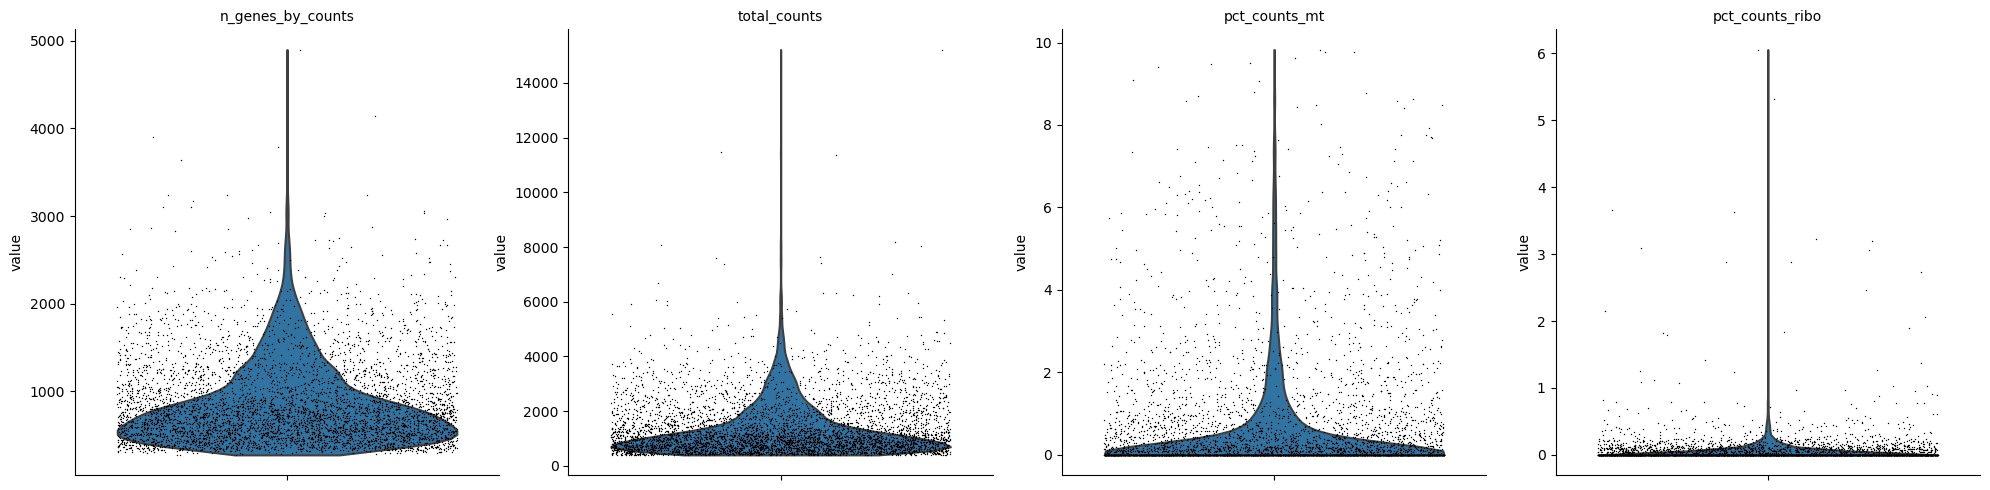

In [28]:
# Plot the quality control metrics to look for outliers to exclude
sc.pl.violin(data1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.4, multi_panel=True)

In [29]:
# Use numpy to find and filter the 98 percentile value
import numpy as np

In [30]:
upper_lim = np.quantile(data1.obs.n_genes_by_counts.values, .98)
upper_lim

2143.0

In [31]:
data1 = data1[data1.obs.n_genes_by_counts < upper_lim]
data1.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161
CATAAGCCACCCAACG-1_1,False,2126,4728.0,1.0,0.021151,2.0,0.042301
GATGACTGTACCCAGC-1_1,False,2007,4598.0,6.0,0.130492,3.0,0.065246
TCCGAAACAGGTACGA-1_1,False,2123,4481.0,18.0,0.401696,4.0,0.089266
TGGGCTGTCTACTTCA-1_1,False,2051,4406.0,6.0,0.136178,0.0,0.000000
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [32]:
# Filter out the top 20% of pct_counts_mt
data1 = data1[data1.obs.pct_counts_mt < 20]
data1.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161
CATAAGCCACCCAACG-1_1,False,2126,4728.0,1.0,0.021151,2.0,0.042301
GATGACTGTACCCAGC-1_1,False,2007,4598.0,6.0,0.130492,3.0,0.065246
TCCGAAACAGGTACGA-1_1,False,2123,4481.0,18.0,0.401696,4.0,0.089266
TGGGCTGTCTACTTCA-1_1,False,2051,4406.0,6.0,0.136178,0.0,0.000000
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [33]:
#Filter out pct_counts_ribo above the value 2 (check the violin plot)
data1 = data1[data1.obs.pct_counts_ribo < 2]
data1.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161
CATAAGCCACCCAACG-1_1,False,2126,4728.0,1.0,0.021151,2.0,0.042301
GATGACTGTACCCAGC-1_1,False,2007,4598.0,6.0,0.130492,3.0,0.065246
TCCGAAACAGGTACGA-1_1,False,2123,4481.0,18.0,0.401696,4.0,0.089266
TGGGCTGTCTACTTCA-1_1,False,2051,4406.0,6.0,0.136178,0.0,0.000000
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [34]:
# The data has now been cleaned for doublets and outliers and is ready for clustering and analysis
data1

View of AnnData object with n_obs × n_vars = 4937 × 23501
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

# Normalisation

In [36]:
# Permits comparison of cells and genes by normalising the data to account for biases arising from sequencing, etc
data1.X.sum(axis = 1)

array([5250., 4727., 4596., ...,  410.,  405.,  410.], dtype=float32)

In [37]:
# Normalise every cell to 10,000 UMI
sc.pp.normalize_total(data1, target_sum=1e4)

C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [39]:
# The data has now been normalised
data1.X.sum(axis = 1)

# Change to log counts and recall
sc.pp.log1p(data1)
data1.X.sum(axis = 1)

array([2858.1602, 3120.9375, 2949.812 , ..., 1191.2706, 1022.7511,
       1162.8785], dtype=float32)

In [41]:
# Data is now comparable and must be saved in this instance - many functions use this .raw data
data1.raw = data1

# Clustering

In [42]:
# Find 2000 top highly variable genes - adds in stats about gene variability
sc.pp.highly_variable_genes(data1, n_top_genes=2000)
data1.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,5,0.000989,99.901068,5.0,5,True,0.011561,2.815524,1.275607
AL627309.5,False,False,23,0.004551,99.544915,23.0,23,False,0.028632,2.392084,-0.046690
LINC01409,False,False,199,0.042541,96.062525,215.0,199,False,0.269179,2.378462,-0.089228
FAM87B,False,False,4,0.000791,99.920855,4.0,4,False,0.005656,1.980269,-1.332683
LINC01128,False,False,55,0.011278,98.911753,57.0,55,False,0.106519,2.573269,0.519106
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,False,False,97,0.019391,98.080728,98.0,97,False,0.158972,2.456721,0.155155
AL592183.1,False,False,721,0.165216,85.734072,835.0,721,False,0.867399,2.553546,-0.415641
AC240274.1,False,False,118,0.023744,97.665216,120.0,118,False,0.150848,2.357423,-0.154926
AC007325.4,False,False,3,0.000594,99.940641,3.0,3,False,0.002848,1.662052,-2.326394


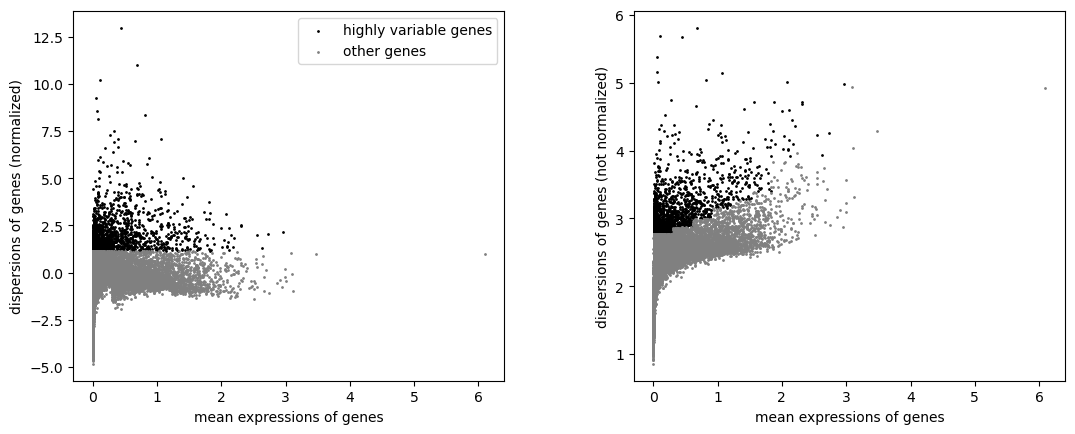

In [43]:
# Highly variable genes can be plotted easily using scanpy function
sc.pl.highly_variable_genes(data1)

In [44]:
# Filter out not highly variable genes - this does not impact the .raw data save
data1 = data1[:, data1.var.highly_variable]
data1

View of AnnData object with n_obs × n_vars = 4937 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [46]:
# Regress out the differences arising from total counts, mitochondrial counts and ribosomal counts
# This removes variations in the data that are due to processing and sample quality
sc.pp.regress_out(data1, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])
data1

AnnData object with n_obs × n_vars = 4937 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [47]:
# Normalise each gene to the unit variance of each gene
sc.pp.scale(data1, max_value=10)

In [49]:
# Run PCA (Principle Component Analysis) to reduce the data dimensions
sc.tl.pca(data1, svd_solver='arpack')
# Neighbourhood looks at distance and creates a matrix which is used for clustering
sc.pp.neighbors(data1, n_pcs=30)

In [50]:
# Use umap to project the data from ~30 dimensions to just 2 - each point is a single cell
sc.tl.umap(data1)

C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


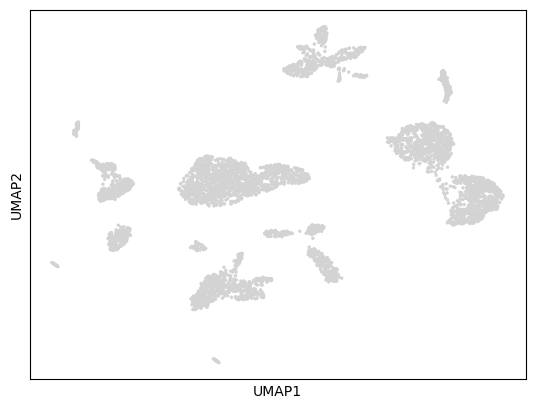

In [51]:
sc.pl.umap(data1)

In [60]:
# Assigning clusters requires the leiden algorithm
# !pip install leidenalg

In [53]:
#Run the leiden algorithm to generate clusters - Resolution [0-1] where 0 is the least clusters and 1 is the most
sc.tl.leiden(data1, resolution=0.5)

In [54]:
# Leiden column has now been added to the observations table
data1.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2
CATAAGCCACCCAACG-1_1,False,2126,4728.0,1.0,0.021151,2.0,0.042301,1
GATGACTGTACCCAGC-1_1,False,2007,4598.0,6.0,0.130492,3.0,0.065246,2
TCCGAAACAGGTACGA-1_1,False,2123,4481.0,18.0,0.401696,4.0,0.089266,12
TGGGCTGTCTACTTCA-1_1,False,2051,4406.0,6.0,0.136178,0.0,0.000000,1
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,7
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,1
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,0
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,5


C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


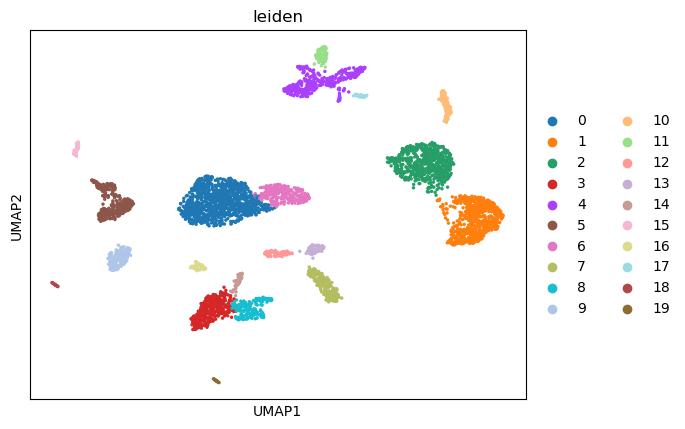

In [55]:
# The cells can now be coloured based on the leiden label
sc.pl.umap(data1, color=['leiden'])

# Integration of multiple samples

In [61]:
# Function for doublet removal, pre-processing and formatting

def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [62]:
import os

In [63]:
# Function for only taking .csv files in the directory, processing with pp function, and then appending to output

def integrate_csv_data(directory):
    out = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            csv_path = os.path.join(directory, file)
            out.append(pp(csv_path))
    return out

In [65]:
# Run the data integration and save to the variable data2
data2 = integrate_csv_data("C:/Users/chris/Single cell practice/")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████████████| 400/400 [09:41<00:00,  1.46s/it, v_num=1, train_loss_step=355, train_loss_epoch=323]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████| 400/400 [09:41<00:00,  1.45s/it, v_num=1, train_loss_step=355, train_loss_epoch=323]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 189/400:  47%|████▎    | 189/400 [00:56<01:03,  3.32it/s, v_num=1, train_loss_step=0.259, train_loss_epoch=0.295]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.296. Signaling Trainer to stop.


C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████████████| 400/400 [07:45<00:00,  1.12s/it, v_num=1, train_loss_step=457, train_loss_epoch=397]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████| 400/400 [07:45<00:00,  1.16s/it, v_num=1, train_loss_step=457, train_loss_epoch=397]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 206/400:  52%|████▋    | 206/400 [00:46<00:43,  4.42it/s, v_num=1, train_loss_step=0.215, train_loss_epoch=0.301]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.285. Signaling Trainer to stop.


C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████████████| 400/400 [12:09<00:00,  1.82s/it, v_num=1, train_loss_step=344, train_loss_epoch=332]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████| 400/400 [12:09<00:00,  1.82s/it, v_num=1, train_loss_step=344, train_loss_epoch=332]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 194/400:  48%|████▊     | 194/400 [01:07<01:11,  2.87it/s, v_num=1, train_loss_step=0.283, train_loss_epoch=0.32]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.301. Signaling Trainer to stop.


C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████████████| 400/400 [07:23<00:00,  1.11s/it, v_num=1, train_loss_step=316, train_loss_epoch=308]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████| 400/400 [07:23<00:00,  1.11s/it, v_num=1, train_loss_step=316, train_loss_epoch=308]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 203/400:  51%|████▌    | 203/400 [00:44<00:43,  4.58it/s, v_num=1, train_loss_step=0.262, train_loss_epoch=0.247]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.220. Signaling Trainer to stop.


C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█████████████| 400/400 [09:16<00:00,  1.39s/it, v_num=1, train_loss_step=305, train_loss_epoch=306]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█████████████| 400/400 [09:16<00:00,  1.39s/it, v_num=1, train_loss_step=305, train_loss_epoch=306]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 159/400:  40%|███▌     | 159/400 [00:44<01:07,  3.57it/s, v_num=1, train_loss_step=0.177, train_loss_epoch=0.227]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.238. Signaling Trainer to stop.


C:\Users\chris\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [66]:
data2

[View of AnnData object with n_obs × n_vars = 5960 × 34546
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 4415 × 34546
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 6928 × 34546
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 4284 × 34546

In [67]:
# Concatonate the datasets into a single object 
data = sc.concat(data2)
data

In [69]:
# Filter out genes present in <10 cells
sc.pp.filter_genes(data, min_cells=10)
data.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [72]:
#Convert to sparse matrix to reduce strain on memory
from scipy.sparse import csr_matrix

In [73]:
data.X = csr_matrix(data.X)
data.X

In [75]:
# Save the data
data.write_h5ad('combined.h5ad')

In [77]:
# Read the saved data file
data = sc.read_h5ad('combined.h5ad')
data

AnnData object with n_obs × n_vars = 27152 × 24995
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells'